<a href="https://colab.research.google.com/github/mariatomy9/Wine_review_sentiment_analysis/blob/main/Wine__Review_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from urllib.request import urlopen
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.svm import SVC, LinearSVC 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Generating dataset and Visual Analysis of data

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Smartknower-Internship/file1.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,variety,winery,quality
0,0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,A Classic
1,1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,A Classic
2,2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,A Classic
3,3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,A Classic
4,4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,Outstanding


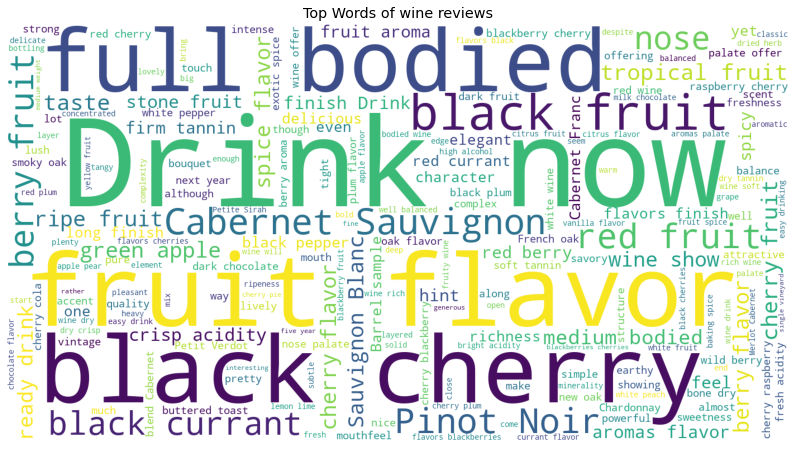

In [ ]:
#WordCloud Analysis for descriptions
plt.figure(figsize = (14,14))

text = ' '.join(df['description'].values)

wordcloud = WordCloud(max_font_size = None, 
                      background_color='white',
                      width=1400, height= 750).generate(text)

plt.imshow(wordcloud)
plt.title('Top Words of wine reviews')

plt.axis('off')
plt.show()

# Pre - Processing (Lemmitisation) and I/O Analysis

In [ ]:
#Lemmitisation
nltk.download('wordnet')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Local funtion to impliment vectorised lemmitisation and reduce computing time
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

#Vectorised implimentation of Lemmitisation
df['text_lemmatized'] = df['description'].apply(lemmatize_text)

print(df.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
   Unnamed: 0  Unnamed: 0.1 country  \
0           0             0      US   
1           1             1   Spain   
2           2             2      US   
3           3             3      US   
4           4             4  France   

                                         description  \
0  This tremendous 100% varietal wine hails from ...   
1  Ripe aromas of fig, blackberry and cassis are ...   
2  Mac Watson honors the memory of a wine once ma...   
3  This spent 20 months in 30% new French oak, an...   
4  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                

In [ ]:
#Lemmitised Descriptions
x = df.iloc[:, 3].values
print(x)

['This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'
 'Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.'
 'Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.'
 ...
 'This classic example comes f

In [ ]:
#Associated sentiment/quality
y = df.iloc[:, -2].values
print(y)

['A Classic' 'A Classic' 'A Classic' ... 'Outstanding' 'Very Good'
 'Very Good']


In [ ]:
print(df['quality'].value_counts())

Very Good      83085
Good           34710
Outstanding    30972
A Classic       1265
Mediocre         898
Name: quality, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       150930 non-null  int64  
 1   Unnamed: 0.1     150930 non-null  int64  
 2   country          150925 non-null  object 
 3   description      150930 non-null  object 
 4   designation      105195 non-null  object 
 5   points           150930 non-null  int64  
 6   price            137235 non-null  float64
 7   province         150925 non-null  object 
 8   region_1         125870 non-null  object 
 9   region_2         60953 non-null   object 
 10  variety          150930 non-null  object 
 11  winery           150930 non-null  object 
 12  quality          150930 non-null  object 
 13  text_lemmatized  150930 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 16.1+ MB


In [ ]:
print(x.shape)
print(y.shape)

(150930,)
(150930,)


# Count Vectorisation

In [ ]:
Vectorised_model = Pipeline([('bow',CountVectorizer(ngram_range = (1, 3))), ('model', LinearSVC())])

In [ ]:
Vectorised_model

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.00

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15, random_state = 42)

In [ ]:
x_train.shape

(128290,)

In [ ]:
x_test.shape

(22640,)

In [ ]:
Vectorised_model.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.00

# Predicting Results

In [ ]:
y_pred = Vectorised_model.predict(x_test)
print(y_pred)

['Good' 'Good' 'Outstanding' ... 'Very Good' 'Outstanding' 'Very Good']


In [ ]:
print(y_test)

['Good' 'Good' 'Outstanding' ... 'Good' 'Outstanding' 'Very Good']


In [ ]:
accuracy_score(y_pred,y_test)

0.8692137809187279

In [ ]:
confusion_matrix(y_test,y_pred)

array([[  122,     0,     0,    71,     4],
       [    0,  4507,     2,     8,   732],
       [    0,    59,    67,     0,     1],
       [    2,    24,     0,  3738,   973],
       [    0,   602,     0,   483, 11245]])

In [ ]:
print(classification_report(y_test,y_pred,labels=['A Classic','Outstanding','Very Good','Good','Mediocre']))

              precision    recall  f1-score   support

   A Classic       0.98      0.62      0.76       197
 Outstanding       0.87      0.79      0.83      4737
   Very Good       0.87      0.91      0.89     12330
        Good       0.87      0.86      0.86      5249
    Mediocre       0.97      0.53      0.68       127

    accuracy                           0.87     22640
   macro avg       0.91      0.74      0.80     22640
weighted avg       0.87      0.87      0.87     22640



# Deployment using Streamlit

In [ ]:
!pip install streamlit

In [ ]:
%%writefile app1.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from sklearn.svm import SVC, LinearSVC


df = pd.read_csv('/content/drive/My Drive/Smartknower-Internship/file1.csv')
x = df.iloc[:,2].values.astype('U') # Message column as input
y = df.iloc[:,-1].values.astype('U') # Label column as output
st.title("Wine Review Classifier")
st.subheader('Count Vectorizer')
st.write('This project is based on LinearSVC Classifier')

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15, random_state = 42)
Vectorised_model = Pipeline([('bow',CountVectorizer(ngram_range = (1, 3))),('model',LinearSVC())])
Vectorised_model.fit(x_train,y_train)
message = st.text_area("Enter Text","Type Here ..")
op = Vectorised_model.predict([message])
if st.button("Predict"):
  st.title(op)

Overwriting app1.py


In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
url = ngrok.connect(port='8501')
url

'http://120c710d6ade.ngrok.io'

In [ ]:
!streamlit run app1.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.91.188.78:8501

  Stopping...
